# Flight Delay Prediction Model

Import the required libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# for pre processing data
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
import scipy.stats as stats

# for statistical analysis
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score,classification_report,confusion_matrix
from sklearn.model_selection import cross_val_score

# for various classification
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

In [2]:
# importing dataset
flight_data = pd.read_csv('airlines_delay.csv')
flight_data.shape

(539382, 8)

In [3]:
flight_data

,Flight,Time,Length,Airline,AirportFrom,AirportTo,DayOfWeek,Class
0,2313.0,1296.0,141.0,DL,ATL,HOU,1,0
1,6948.0,360.0,146.0,OO,COS,ORD,4,0
2,1247.0,1170.0,143.0,B6,BOS,CLT,3,0
3,31.0,1410.0,344.0,US,OGG,PHX,6,0
4,563.0,692.0,98.0,FL,BMI,ATL,4,0
...,...,...,...,...,...,...,...,...
539377,6973.0,530.0,72.0,OO,GEG,SEA,5,1
539378,1264.0,560.0,115.0,WN,LAS,DEN,4,1
539379,5209.0,827.0,74.0,EV,CAE,ATL,2,1
539380,607.0,715.0,65.0,WN,BWI,BUF,4,1


Exploratory Data Analysis-(EDA)

In [4]:
#checking for any null values in our data
flight_data.isnull().sum()

Flight         0
Time           0
Length         0
Airline        0
AirportFrom    0
AirportTo      0
DayOfWeek      0
Class          0
dtype: int64

In [5]:
# Gaining various information for our data

In [6]:
flight_data.columns

Index(['Flight', 'Time', 'Length', 'Airline', 'AirportFrom', 'AirportTo',
       'DayOfWeek', 'Class'],
      dtype='object')

In [7]:
flight_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 539382 entries, 0 to 539381
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Flight       539382 non-null  float64
 1   Time         539382 non-null  float64
 2   Length       539382 non-null  float64
 3   Airline      539382 non-null  object 
 4   AirportFrom  539382 non-null  object 
 5   AirportTo    539382 non-null  object 
 6   DayOfWeek    539382 non-null  int64  
 7   Class        539382 non-null  int64  
dtypes: float64(3), int64(2), object(3)
memory usage: 32.9+ MB


In [8]:
flight_data.describe()

,Flight,Time,Length,DayOfWeek,Class
count,539382.000000,539382.000000,539382.000000,539382.000000,539382.000000
mean,2427.927988,802.728161,132.202104,3.929666,0.445443
std,2067.431700,278.045546,70.117045,1.914666,0.497015
min,1.000000,10.000000,0.000000,1.000000,0.000000
25%,712.000000,565.000000,81.000000,2.000000,0.000000
50%,1809.000000,795.000000,115.000000,4.000000,0.000000
75%,3745.000000,1035.000000,162.000000,5.000000,1.000000
max,7814.000000,1439.000000,655.000000,7.000000,1.000000


Visulization of data to get insights

<Axes: xlabel='Airline', ylabel='count'>

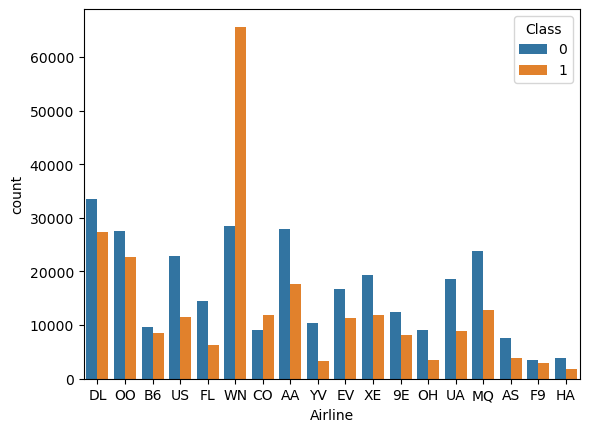

In [9]:
sns.countplot(x = 'Airline', hue = 'Class', data = flight_data)

<Axes: xlabel='Airline', ylabel='Length'>

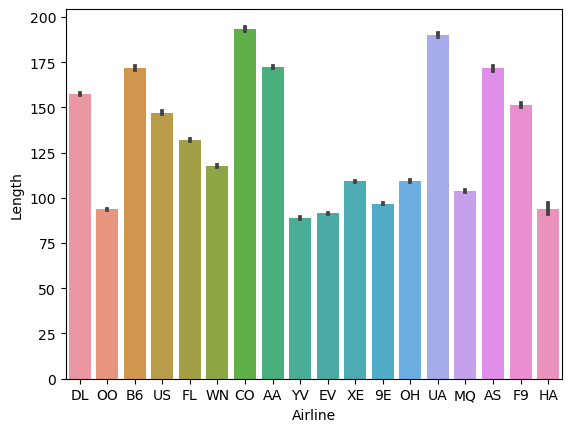

In [10]:
sns.barplot(x = 'Airline',y='Length', data = flight_data)

<Axes: xlabel='Airline', ylabel='Time'>

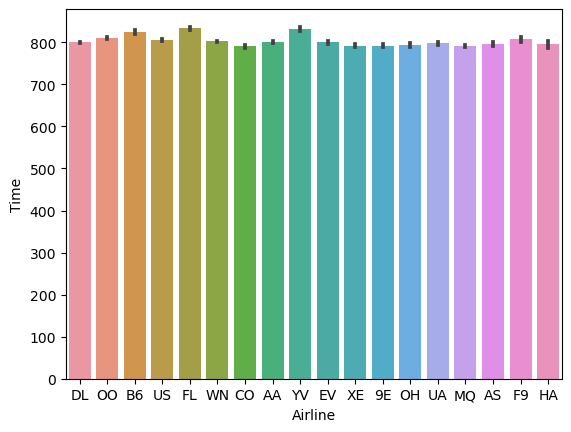

In [11]:
sns.barplot(x = 'Airline', y = 'Time', data = flight_data)

*From above illuistration we get insights on data such as:
WN is highest delay than other airliness,
CO and UA have longest average flight time,
Almost all of the flight have same departure*

Preprocessing of given data

In [12]:
#removing un required data in our model
flight_data = flight_data.drop('Flight', axis =1)
flight_data.head()

,Time,Length,Airline,AirportFrom,AirportTo,DayOfWeek,Class
0,1296.0,141.0,DL,ATL,HOU,1,0
1,360.0,146.0,OO,COS,ORD,4,0
2,1170.0,143.0,B6,BOS,CLT,3,0
3,1410.0,344.0,US,OGG,PHX,6,0
4,692.0,98.0,FL,BMI,ATL,4,0


In [13]:
print(flight_data.dtypes)

Time           float64
Length         float64
Airline         object
AirportFrom     object
AirportTo       object
DayOfWeek        int64
Class            int64
dtype: object


Encoding of various data to make all data in int form for our models

In [14]:
#taking unique values of Airline and encode them
airline = flight_data['Airline'].unique()
airline



array(['DL', 'OO', 'B6', 'US', 'FL', 'WN', 'CO', 'AA', 'YV', 'EV', 'XE',
       '9E', 'OH', 'UA', 'MQ', 'AS', 'F9', 'HA'], dtype=object)

In [15]:
encoder = LabelEncoder()

flight_data['Airline'] = encoder.fit_transform(flight_data['Airline'])
airline_encoded = flight_data['Airline'].unique()
airline_dict = {airline[i]:airline_encoded[i] for i in range(len(airline))}  # making dictionary for User input encodes
flight_data['Airline'].unique()


array([ 5, 12,  3, 14,  8, 15,  4,  1, 17,  6, 16,  0, 11, 13, 10,  2,  7,
        9])

In [16]:
# taking unique values of AirportFrom and encode them
air_from = flight_data['AirportFrom'].unique()
air_from

array(['ATL', 'COS', 'BOS', 'OGG', 'BMI', 'MSY', 'EWR', 'DFW', 'BWI',
       'CRW', 'LGB', 'BIS', 'CLT', 'IAH', 'LAX', 'JAX', 'SAV', 'CLE',
       'FLL', 'SAN', 'BHM', 'ROC', 'DTW', 'STT', 'AUS', 'DCA', 'PHX',
       'EYW', 'IND', 'JFK', 'ORD', 'PBI', 'SFO', 'MIA', 'DSM', 'SLC',
       'PHL', 'BZN', 'GRB', 'MBS', 'SBA', 'TYS', 'MSP', 'DEN', 'SAT',
       'BUF', 'RIC', 'SEA', 'PDX', 'LAS', 'IAD', 'HNL', 'BDL', 'MOT',
       'PSE', 'CPR', 'SNA', 'STL', 'CVG', 'PIT', 'HSV', 'SGF', 'RDU',
       'MEM', 'KOA', 'ELP', 'SJU', 'JAN', 'AEX', 'LGA', 'RSW', 'MDT',
       'GUC', 'MKE', 'CAE', 'GRR', 'FAR', 'LIT', 'OMA', 'BNA', 'EVV',
       'RDD', 'OKC', 'ITO', 'SJC', 'MCO', 'LBB', 'CSG', 'OAK', 'PHF',
       'ABQ', 'SMF', 'FAY', 'ABI', 'MSO', 'MFE', 'GEG', 'MSN', 'TPA',
       'DAY', 'RNO', 'PVD', 'ALB', 'CHO', 'ONT', 'LIH', 'PSP', 'LAN',
       'LEX', 'XNA', 'GJT', 'CMH', 'GSO', 'PSC', 'SYR', 'AVL', 'MHT',
       'GRK', 'MCI', 'TXK', 'LRD', 'ABE', 'LWB', 'ERI', 'DAL', 'ANC',
       'TUS', 'ROA',

In [17]:
flight_data['AirportFrom'] = encoder.fit_transform(flight_data['AirportFrom'])
air_from_encoded = flight_data['AirportFrom'].unique()
air_from_dict = {air_from[i]:air_from_encoded[i] for i in range(len(air_from))} # for user input encodes
flight_data['AirportFrom'].unique()

array([ 16,  65,  35, 203,  32, 198,  96,  80,  45,  69, 160,  29,  60,
       135, 154, 147, 245,  58, 104, 243,  27, 238,  85, 269,  18,  78,
       217,  97, 139, 148, 208, 213, 253, 183,  84, 261, 216,  46, 117,
       171, 246, 285, 197,  79, 244,  43, 234, 252, 214, 153, 134, 128,
        22, 192, 225,  67, 264, 268,  71, 221, 132, 254, 233, 177, 150,
        91, 260, 146,  10, 159, 241, 174, 124, 184,  47, 119,  99, 162,
       205,  33,  94, 231, 204, 143, 258, 173, 155,  70, 202, 215,   2,
       262, 101,   1, 196, 178, 111, 195, 277,  76, 236, 228,  12,  53,
       207, 161, 227, 152, 157, 290, 114,  61, 120, 224, 273,  19, 182,
       118, 172, 283, 165,   0, 167,  92,  75,  14, 280, 237, 191, 149,
       248,  50, 279, 107, 106,  42, 102, 115, 230, 175, 109,  44, 223,
       240, 129,  34,  68,  38,  17, 256, 263, 232, 209, 116, 151, 136,
       242,  48, 137, 193, 288,  54, 170, 130,  20,  21, 278, 121, 126,
       188,  93,  13, 181, 141,  56, 190,  26, 267, 187,  89, 15

In [18]:
# taking unique values of Airport and encode them
air_to = flight_data['AirportTo'].unique()
air_to

array(['HOU', 'ORD', 'CLT', 'PHX', 'ATL', 'BHM', 'DFW', 'MEM', 'GRR',
       'PBI', 'MCO', 'SFO', 'DEN', 'YUM', 'BWI', 'HPN', 'EWR', 'JFK',
       'MKE', 'OAK', 'IAH', 'CLE', 'SYR', 'SJU', 'BDL', 'SAN', 'DTW',
       'PSP', 'DCA', 'LGA', 'STL', 'FAY', 'MSP', 'BUF', 'LAS', 'SGU',
       'SLC', 'GJT', 'LAX', 'VPS', 'FAR', 'RKS', 'BOS', 'ANC', 'SNA',
       'ONT', 'RNO', 'JAX', 'GSP', 'CVG', 'TPA', 'SEA', 'LEX', 'SMF',
       'CAE', 'STT', 'DAY', 'MDW', 'RSW', 'ITO', 'IAD', 'ICT', 'HNL',
       'MIA', 'CRW', 'RDU', 'MHT', 'FAT', 'CAK', 'COS', 'DAL', 'TYS',
       'PHL', 'ABI', 'MOB', 'SDF', 'SAV', 'MDT', 'LIT', 'TUL', 'ACV',
       'BNA', 'MCI', 'MSY', 'FLL', 'PVD', 'OKC', 'ECP', 'PHF', 'AUS',
       'RIC', 'LIH', 'ABQ', 'JAN', 'PIT', 'BMI', 'BTV', 'RAP', 'MRY',
       'CSG', 'SHV', 'FAI', 'SJC', 'PIA', 'SBN', 'IND', 'SGF', 'ACT',
       'SRQ', 'ROC', 'CHO', 'JAC', 'SAT', 'FWA', 'OMA', 'PDX', 'CMH',
       'PWM', 'CID', 'TRI', 'ORF', 'GTF', 'TUS', 'MHK', 'BUR', 'MLU',
       'CEC', 'TEX',

In [19]:
flight_data['AirportTo'] = encoder.fit_transform(flight_data['AirportTo'])
air_to_encoded = flight_data['AirportTo'].unique()
air_to_dict = {air_to[i]:air_to_encoded[i] for i in range(len(air_to))}
flight_data['AirportTo'].unique()

array([129, 208,  60, 217,  16,  27,  80, 177, 119, 213, 173, 253,  79,
       292,  45, 130,  96, 148, 184, 202, 135,  58, 273, 260,  22, 243,
        85, 227,  78, 159, 268, 101, 197,  43, 153, 255, 261, 114, 154,
       288,  99, 235,  35,  14, 264, 207, 236, 147, 121,  71, 277, 252,
       157, 262,  47, 269,  76, 175, 241, 143, 134, 136, 128, 183,  69,
       233, 182, 100,  48,  65,  75, 285, 216,   1, 190, 251, 245, 174,
       162, 279,   6,  33, 172, 198, 104, 228, 204,  87, 215,  18, 234,
       161,   2, 146, 221,  32,  42, 230, 194,  70, 256,  98, 258, 218,
       247, 139, 254,   5, 267, 238,  53, 145, 244, 109, 205, 214,  61,
       229,  56, 278, 209, 122, 280, 181,  44, 188,  51, 274, 171,  84,
       131, 158,  91,  10,  67, 155, 200,  12,  66, 166,  52, 187, 111,
        21, 179,  41, 103, 151, 224, 120, 203, 195, 116, 223, 232,  46,
        82,  68, 283, 150, 193, 170, 275, 290,  72, 248,  24,  83, 289,
        81, 266,  13,  88,  23, 102,  93,  94,  19, 132, 219, 18

In [20]:
flight_data.dtypes

Time           float64
Length         float64
Airline          int32
AirportFrom      int32
AirportTo        int32
DayOfWeek        int64
Class            int64
dtype: object

 ReSampling Train Data

Class
0    299118
1    240264
Name: count, dtype: int64

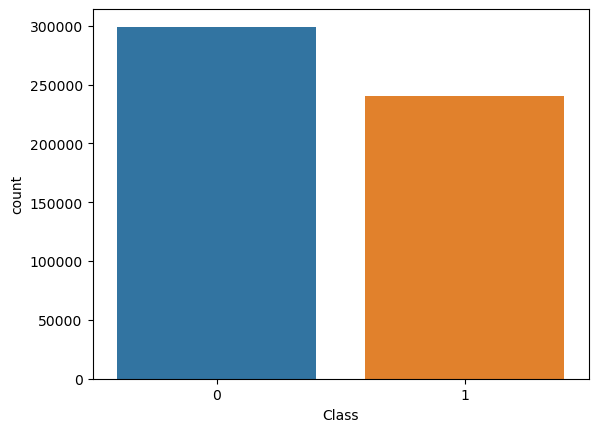

In [21]:
sns.countplot(x='Class',data = flight_data)
flight_data['Class'].value_counts()

In [22]:
# Dividing data into majority and minority
flight_major = flight_data[(flight_data['Class']==0)]
flight_minor = flight_data[(flight_data['Class']==1)]
# Umsampling minor data

flight_minor_upsample = resample(flight_minor,replace = True ,n_samples = len(flight_major),random_state = 0)

# combining both data

flight_upsampled = pd.concat([flight_minor_upsample, flight_major])

Class
1    299118
0    299118
Name: count, dtype: int64

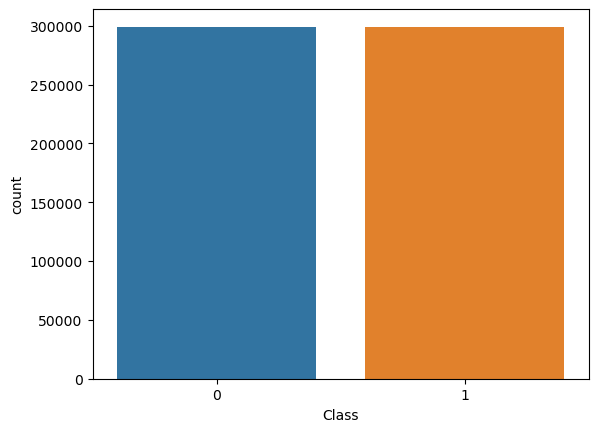

In [23]:
sns.countplot(x='Class',data = flight_upsampled)
flight_upsampled['Class'].value_counts()

Removing Outliers from data

In [24]:
z= np.abs(stats.zscore(flight_upsampled))
final_train = flight_upsampled[(z<3).all(axis=1)]
final_train.shape

(587262, 7)

Attribute Correlation

<Axes: >

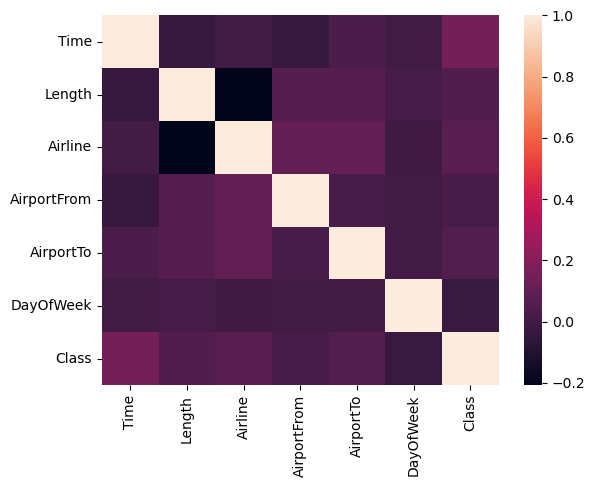

In [25]:
sns.heatmap(final_train.corr(), fmt = '.2g')

Splitting data into train and test data

In [26]:
#dividing data into dependent and undependent feature 
x = final_train.drop('Class', axis=1)
y = final_train['Class']

In [27]:
x_train,x_test,y_train,y_test=train_test_split(x,y, test_size=0.2, random_state=42)

In [28]:
x_train

,Time,Length,Airline,AirportFrom,AirportTo,DayOfWeek
427105,480.0,185.0,1,208,183,3
144791,1160.0,280.0,5,85,153,1
522522,1325.0,99.0,5,197,230,5
438359,420.0,68.0,5,153,154,1
121236,525.0,50.0,10,243,154,2
...,...,...,...,...,...,...
161104,690.0,55.0,4,135,18,5
370236,665.0,65.0,15,153,243,6
121726,690.0,70.0,6,47,16,4
534202,948.0,102.0,8,173,215,7


In [29]:
x_test

,Time,Length,Airline,AirportFrom,AirportTo,DayOfWeek
522508,1205.0,95.0,15,33,209,1
439972,1329.0,92.0,6,134,229,2
55997,1370.0,50.0,1,80,204,4
202472,1280.0,280.0,1,154,183,2
150532,811.0,257.0,5,16,217,2
...,...,...,...,...,...,...
257953,735.0,104.0,0,16,268,3
420837,565.0,150.0,15,153,18,7
68612,420.0,85.0,14,209,60,5
98937,1120.0,180.0,1,208,244,5


In [30]:
y_train

427105    1
144791    1
522522    1
438359    0
121236    0
         ..
161104    1
370236    1
121726    0
534202    1
317748    1
Name: Class, Length: 469809, dtype: int64

In [31]:
y_test

522508    1
439972    0
55997     0
202472    1
150532    1
         ..
257953    1
420837    1
68612     0
98937     1
97004     1
Name: Class, Length: 117453, dtype: int64

### Implementation of various models



***Logistic Regression***

In [32]:
logistic_model = LogisticRegression()

In [33]:
logistic_model.fit(x_train,y_train)

LogisticRegression()

In [34]:
log_pred =logistic_model.predict(x_test)
print("Accuracy Score : ",round(accuracy_score(y_test,log_pred)*100,2),'%')

Accuracy Score :  57.71 %


In [35]:
print("F-1 Score : ",round(f1_score(y_test,log_pred)*100,2),'%')
print("Precision Score : ",round(precision_score(y_test,log_pred)*100,2),'%')
print("Recall Score : ",round(recall_score(y_test,log_pred)*100,2),'%')

F-1 Score :  57.53 %
Precision Score :  57.55 %
Recall Score :  57.51 %


***Decision Tree Classifier***

In [36]:
dt_classifier= DecisionTreeClassifier()


dt_classifier.fit(x_train,y_train)


y_pred=dt_classifier.predict(x_test)
print("Accuracy Score : ", round(accuracy_score(y_test,y_pred)*100,2),'%')

Accuracy Score :  68.24 %


In [37]:
print("F-1 Score : ",round(f1_score(y_test,y_pred)*100,2),'%')
print("Precision Score : ",round(precision_score(y_test,y_pred)*100,2),'%')
print("Recall Score : ",round(recall_score(y_test,y_pred)*100,2),'%')


F-1 Score :  67.62 %
Precision Score :  68.68 %
Recall Score :  66.59 %


***Random Forest Classifier***

In [38]:
rf_classifier=RandomForestClassifier(random_state=0)


rf_classifier.fit(x_train,y_train)


rf_predict=rf_classifier.predict(x_test)
print("Accuracy Score : ", round(accuracy_score(y_test,rf_predict)*100,2),'%')

Accuracy Score :  70.07 %


In [39]:
print("F-1 Score : ",round(f1_score(y_test,rf_predict)*100,2),'%')
print("Precision Score : ",round(precision_score(y_test,rf_predict)*100,2),'%')
print("Recall Score : ",round(recall_score(y_test,rf_predict)*100,2),'%')

F-1 Score :  70.89 %
Precision Score :  68.74 %
Recall Score :  73.18 %


***AdaBoost Classifier***

In [40]:
ada_model= AdaBoostClassifier()
ada_model.fit(x_train,y_train)
ada_pred=ada_model.predict(x_test)
print("Accuracy Score : ", round(accuracy_score(y_test,ada_pred)*100,2),'%')

Accuracy Score :  62.79 %


In [41]:
print("F-1 Score : ",round(f1_score(y_test,ada_pred)*100,2),'%')
print("Precision Score : ",round(precision_score(y_test,ada_pred)*100,2),'%')
print("Recall Score : ",round(recall_score(y_test,ada_pred)*100,2),'%')

F-1 Score :  61.54 %
Precision Score :  63.42 %
Recall Score :  59.76 %


***Naive Bayes***

In [42]:
gnb = GaussianNB()
gnb.fit(x_train, y_train)
y_pred = gnb.predict(x_test)
print("Accuracy Score : ", round(accuracy_score(y_test,y_pred)*100,2),'%')

Accuracy Score :  57.99 %


In [43]:
print("F-1 Score : ",round(f1_score(y_test,y_pred)*100,2),'%')
print("Precision Score : ",round(precision_score(y_test,y_pred)*100,2),'%')
print("Recall Score : ",round(recall_score(y_test,y_pred)*100,2),'%')

F-1 Score :  58.97 %
Precision Score :  57.42 %
Recall Score :  60.61 %


***KNN Classifer***

In [44]:
knn = KNeighborsClassifier()
knn.fit(x_train, y_train)
y_pred = knn.predict(x_test)
print("Accuracy Score : ", round(accuracy_score(y_test,y_pred)*100,2),'%')

Accuracy Score :  67.69 %


In [45]:
print("F-1 Score : ",round(f1_score(y_test,y_pred)*100,2),'%')
print("Precision Score : ",round(precision_score(y_test,y_pred)*100,2),'%')
print("Recall Score : ",round(recall_score(y_test,y_pred)*100,2),'%')

F-1 Score :  68.49 %
Precision Score :  66.59 %
Recall Score :  70.49 %


***Voting Classifier***

In [46]:
model_1 = LogisticRegression()

model_1.fit(x_train, y_train)

ypred_model_1 = model_1.predict(x_test)


model_2 = GaussianNB()

model_2.fit(x_train, y_train)

ypred_model_2 = model_2.predict(x_test)


model_3 = RandomForestClassifier()

model_3.fit(x_train, y_train)

ypred_model_3 = model_3.predict(x_test)


eclf = VotingClassifier(

 estimators=[('lr', model_1), ('rf', model_2), ('gnb', model_3)],

 voting='hard'

)



In [47]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
for clf, label in zip([model_1, model_2, model_3, eclf], ['Logistic Regression', 'Naive Bayes', 'Random Forest', 'Ensemble']):
    scores = cross_val_score(clf, x, y, scoring='accuracy', cv=5)

print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

Accuracy: nan (+/- nan) [Ensemble]


| Model | Testing Accuracy | F-1 Score|Precision Score|Recall Score|
|----------|---------|-------------------------|-|-|
| Logistic Regression	| 57.1% | 57.3% |57.55%|57.1%|
|DECISION TREE CLASSIFIER 	| 68.23%	| 67.61% | 68.67% |  68.58% |
|Random Forest Classifier| 70.07%	| 70.89% | 68.74%  | 73.18% |
|AdaBoost Classifier 	| 62.79%	| 61.54% | 63.42%|59.76%|
| Naive Bayes| 57.99%	| 58.97% | 57.42%|60.41%|
|KNN Classifer 	|  67.66%	| 68.44% | 66.6%|70.38%|



In [48]:
eclf

VotingClassifier(estimators=[('lr', LogisticRegression()), ('rf', GaussianNB()),
                             ('gnb', RandomForestClassifier())])

*Via performing on various model we get that Random Forest Classifer performs best in our case *

### Visualizing Our Training Model

Text(0.5, 1.0, 'Accuracy Score : 0.7006547299770972')

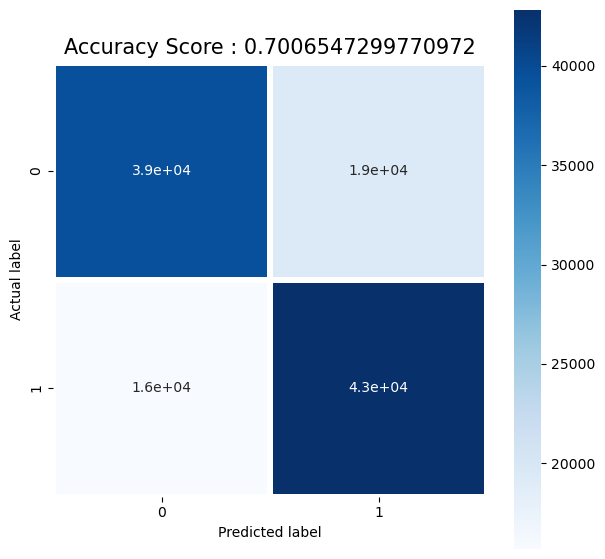

In [49]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test,rf_predict)
plt.figure(figsize=(7,7))
sns.heatmap(data=cm,linewidth=3, annot=True, square=True, cmap='Blues')
plt.xlabel("Predicted label")
plt.ylabel("Actual label")
all_sample_title = 'Accuracy Score : {0}'.format(rf_classifier.score(x_test,y_test))
plt.title(all_sample_title, size=15)